# Build a Molecular Search Engine in Minutes

This notebook illustrates how to build a molecular search engine from scratch using Milvus. Milvus is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries. We will go through molecular **similarity search**, **substructure and superstructure search** procedures and evaluate performance. Moreover, we managed to make the core functionality as simple as 10 lines of code, with which you can start hacking your own molecular search engine.

## Preparations

### Install Dependencies

First we need to install dependencies such as milvus, towhee, rdkit and gradio.

> There are several ways to install Milvus. You can [install Milvus Standalone](https://milvus.io/docs/v2.0.x/install_standalone-docker.md) or [install Milvus Cluster](https://milvus.io/docs/v2.0.x/install_cluster-docker.md). The `pip install milvus` in this notebook is still in internal testing, if you plan to put it into production please use another method.

In [1]:
! python -m pip install -q milvus towhee rdkit-pypi gradio

### Prepare the Data

There is a subset of the [Pubchem dataset](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/) (10000 SMILES) used in this demo, everyone can download on [Github](https://github.com/towhee-io/data/raw/main/chemical/pubchem_1w.smi).

In [2]:
! curl -L https://github.com/towhee-io/data/raw/main/chemical/pubchem_1w.smi -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  561k  100  561k    0     0  53419      0  0:00:10  0:00:10 --:--:-- 17863  0:00:08  0:00:01 27327


**pubchem_1w.smi**: a file containing SMILES and corresponding ids.

Let's take a quick look:

In [3]:
import pandas as pd

df = pd.read_csv('pubchem_1w.smi')
df.head()

,smiles,id
0,COc1cc(C=NNC(=O)CC2(C)OCCO2)cc(c1OCc1cccc2c1cc...,2860827
1,Fc1ccc(cc1)C=C1C(=O)NC(=S)N(C1=O)c1ccc(cc1Cl)Cl,2860828
2,O=C1NC(=C(C(N1)c1cccc(c1)Br)C(=O)Nc1ccc(cc1)Cl)C,2860829
3,COc1ccc(c(c1)OC)C=C1C(=O)NC(=S)N(C1=O)c1cccc(c...,2860830
4,Nc1ccn(n1)c1ccccc1.Cl,2860831


To use the dataset for molecular search, let's first define the dictionary and helper function:
- `id_smiles`: a dictionary of id and corresponding smiles;
- `to_images(input)`: convert the input smiles or results to towhee.Image for display.

In [4]:
from rdkit.Chem import Draw
from rdkit import Chem
from towhee.types.image_utils import from_pil

id_smiles = df.set_index('id')['smiles'].to_dict()

def to_images(inputs):
    if isinstance(inputs, str):
        smiles = inputs
        mol = Chem.MolFromSmiles(smiles)
        return from_pil(Draw.MolToImage(mol))
    imgs = []
    results = inputs
    for re in results:
        smiles = id_smiles[re.id]
        mol = Chem.MolFromSmiles(smiles)
        imgs.append(from_pil(Draw.MolToImage(mol)))
    return imgs

### Start Milvus and Create Collection

Next we need to start Milvus and create a Milvus Collection, first run `milvus.before()` and make sure that the current environment has completed for first Milvus environment configuration.

In [5]:
import milvus
milvus.before()

---(For linux users) if you are running Milvus for the first time, run milvus.before() for env variables setting instructions---
---otherwise, run milvus.start()---
please set the following env variables in bash:
export LD_PRELOAD=/Users/chenshiyu/.virtualenvs/shiyu/lib/python3.8/site-packages/milvus/bin/embd-milvus.so
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/lib:/usr/local/lib:/tmp/milvus/lib


Then we need to set environment variables, and please change the "LD_PRELOAD" variable to the above output.

If `milvus.before()` also shows that dependencies need to be installed, please run `sh install_deps.sh` on your machine.

In [6]:
import os
os.environ["LD_PRELOAD"] = "/Users/chenshiyu/.virtualenvs/shiyu/lib/python3.8/site-packages/milvus/bin/embd-milvus.so"
os.environ["LD_LIBRARY_PATH"] = "$LD_LIBRARY_PATH:/usr/lib:/usr/local/lib:/tmp/milvus/lib"

Once Milvus is ready, you can run `milvus.start()`, which may take a few minutes until printing **"---Milvus agent successfully initialized and ready to serve!--"**. Without `time.sleep(`) the result of this line may be printed to the notebook's command line after a few minutes, you can check jupyter's output. So please make sure milvus has started with printing that line.

In [7]:
import time
milvus.start()
time.sleep(30)

---Milvus Proxy successfully initialized and ready to serve!---


Next to create the `molecular_search` collection in Milvus. It's worth to note that the vector field of this collection is the type of "BINARY_VECTOR".

In [8]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.BINARY_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='molecular similarity search')
    collection = Collection(name=collection_name, schema=schema)
    
    return collection

collection = create_milvus_collection('molecular_search', 2048)

## Molecular Search Engine

In this section, we will show how to build our molecular search engine using Milvus. The basic idea behind Molecular Search is to use Towhee to generate molecular fingerprints from SMILES and compare the queried fingerprints with the fingerprints stored in Milvus.

We use Towhee, a machine learning framework that allows the creation of data processing pipelines. Towhee also provides predefined operators for implementing insert and query operations in Milvus.

### Load Molecular Fingerprint into Milvus

We first generate fingerprint from SMILES with daylight algorithm and insert the fingerprints into Milvus. Towhee provides a [method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) so that users can assemble a data processing pipeline with operators.

In [9]:
import towhee

In [10]:
%%time
dc = (
    towhee.read_csv('pubchem_1w.smi')
      .runas_op['id', 'id'](func=lambda x: int(x))
      .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
      .to_milvus['id', 'fp'](collection=collection, batch=100)
)

CPU times: user 16.1 s, sys: 2.31 s, total: 18.5 s
Wall time: 21.6 s


In [11]:
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 10000.


#### Explanation of Data Processing Pipeline

Here is detailed explanation for each line of the code:

`towhee.read_csv('pubchem_1w.smi')`: read tabular data from the file (smiles and id columns);

`.runas_op['id', 'id'](func=lambda x: int(x))`: for each row from the data, convert the data type of the column id from `str` to `int`;

`.molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')`: use the daylight algorithm to generate fingerprint with the [rdkit operator](https://towhee.io/molecular-fingerprinting/rdkit) in towhee hub.

`.to_milvus['id', 'fp'](collection=collection, batch=100)`: insert molcular fingerprints in to Milvus;

Then we decompose the pipeline into stages to get a more intuitive understanding of what's going on

- read data from csv, get a tabular data with two columns

In [12]:
towhee.read_csv('pubchem_1w.smi').show()

smiles,id
COc1cc(C=NNC(=O)CC2(C)OCCO2)cc(c...,2860827
Fc1ccc(cc1)C=C1C(=O)NC(=S)N(C1=O...,2860828
O=C1NC(=C(C(N1)c1cccc(c1)Br)C(=O...,2860829
COc1ccc(c(c1)OC)C=C1C(=O)NC(=S)N...,2860830
Nc1ccn(n1)c1ccccc1.Cl,2860831


- add `runas_op` to convert the data type

In [13]:
dc1 = towhee.read_csv('pubchem_1w.smi').to_list()
dc2 = towhee.read_csv('pubchem_1w.smi').runas_op['id', 'id'](func=lambda x: int(x)).to_list()
print(dc1[0].id, dc2[0].id, type(dc1[0].id), type(dc2[0].id))

2860827 2860827 <class 'str'> <class 'int'>


- generate fingerprint with `fp` column

In [14]:
towhee.read_csv('pubchem_1w.smi') \
      .head(2) \
      .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight') \
      .show()

smiles,id,fp
COc1cc(C=NNC(=O)CC2(C)OCCO2)cc(c...,2860827,b'\xa1\x00\x88#\x067\xb0\xa9S\xa2\x8c8\x8b\xc25\xe3\x01\x98b@G\x8dQ\x85\xa6(\xb1B \x16\xa0`\x00dFL\x00\x7f\x93\x02\x8e\x0b\xe4\...
Fc1ccc(cc1)C=C1C(=O)NC(=S)N(C1=O...,2860828,"b""\xe64\xf0\t\xd2\xfbT\x9eEt(,\xbd\x19\xd3\x82b\xe3\xe8%B\xedx\xd0\xed\xfa\x8f\xf6\x95hM\xb4\xc1\x14Q\\\\\xe3\x10\x0f\x89DW\x94\..."


### Query Molecular from Milvus

Now that fingerprint for candidate SMILES have been inserted into Milvus, we can query across it. Again, we use Towhee to load the input SMILES, compute a fingerprint, and use it as a query in Milvus. Because Milvus only outputs IDs and distance values, we provide the `id_smiles` dictionary to get the original smiles based on IDs and display.

#### similarity search

In [15]:
%%time
( towhee.dc['smiles'](['Cn1ccc(=O)nc1', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CCOC(=O)C1CN1C(C(=O)OCC)CC'])
      .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
      .milvus_search['fp', 'result'](collection=collection, metric_type='JACCARD')
      .runas_op['result', 'similar_smile'](func=lambda res: [id_smiles[x.id] for x in res])
      .select['smiles', 'similar_smile']()
      .show()
)

smiles,similar_smile
Cn1ccc(=O)nc1,"[Cn1ccc(=O)nc1,Cn1c[n+](C)ccc1=O,Cn1cnccc1=O,Cn1ccc(=O)[nH]c1=O,...] len=10"
CN1C=NC2=C1C(=O)N(C(=O)N2C)C,"[Cn1cnc2c1c(=O)n(C)c(=O)n2C,Cn1c2nc[nH]c2c(=O)n(C)c1=O,Cn1cnc2c1c(=O)[nH]c(=O)n2C,Cn1cnc2[nH]c(=O)n(C)c(=O)c21,...] len=10"
CCOC(=O)C1CN1C(C(=O)OCC)CC,"[CCOC(=O)C1CN1C(C(=O)OC)CC,CCCCOC(=O)C1CN1C(C(=O)OCC)CC,CCCCCCOC(=O)C1CN1C(C(=O)OCC)CC,CCC(N1CC1C(=O)OC)C(=O)OC,...] len=10"


CPU times: user 56.1 ms, sys: 138 ms, total: 194 ms
Wall time: 77.9 ms


If you want to show the molecular structure with images, you can use the `to_images` function.

smiles,similar_smile
,
,
,

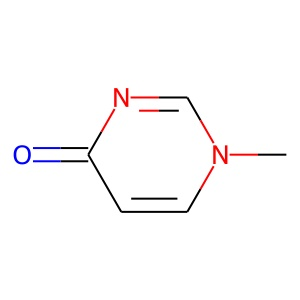
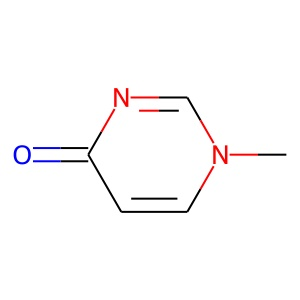
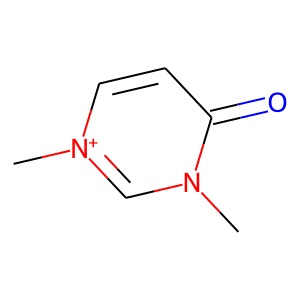
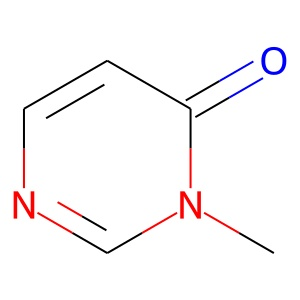
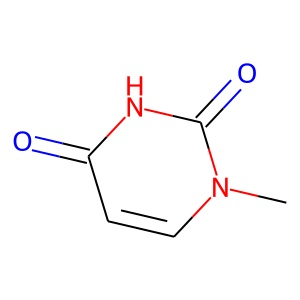
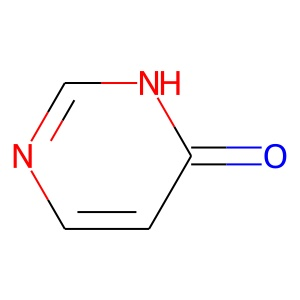
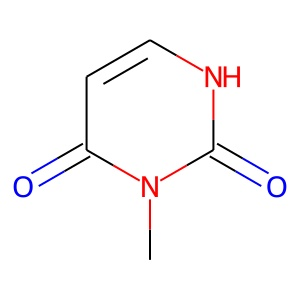
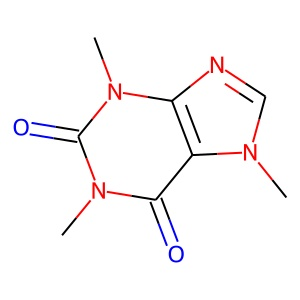
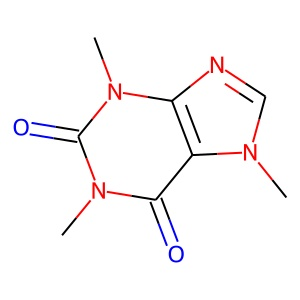
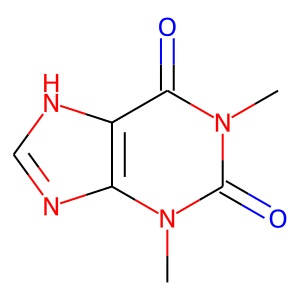
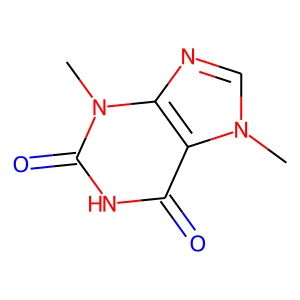
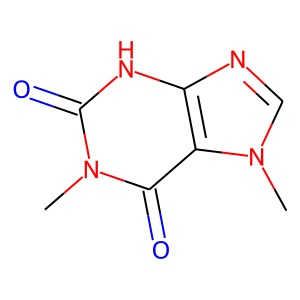
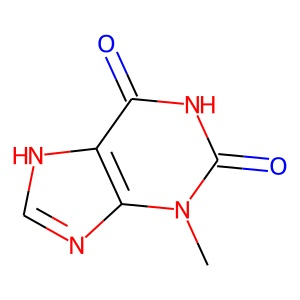
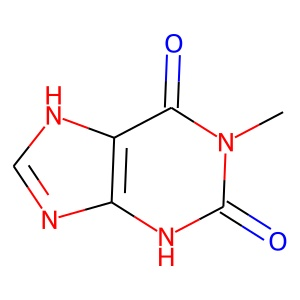
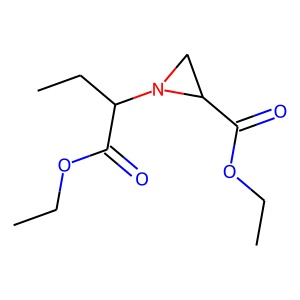
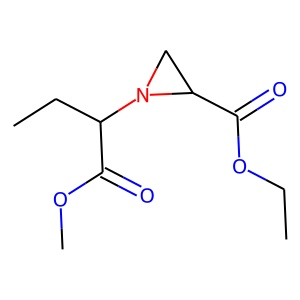
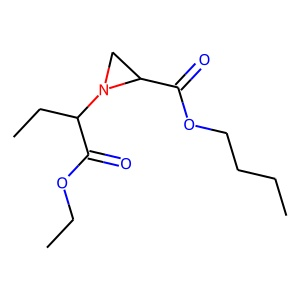
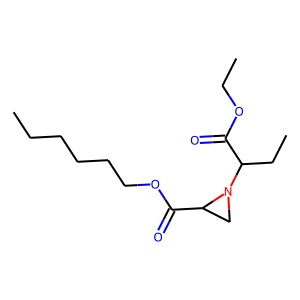
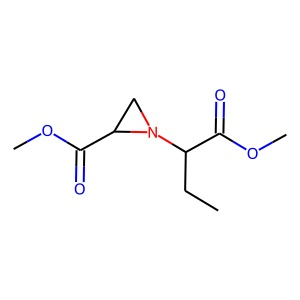
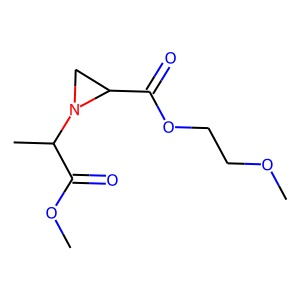
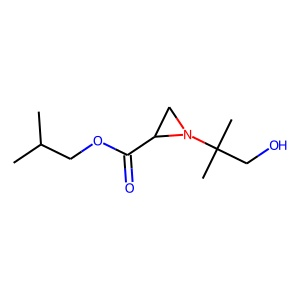

In [16]:
( towhee.dc['smiles'](['Cn1ccc(=O)nc1', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CCOC(=O)C1CN1C(C(=O)OCC)CC'])
      .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
      .milvus_search['fp', 'result'](collection=collection, metric_type='JACCARD', limit=6)
      .runas_op['result', 'similar_smile'](func=to_images)
      .runas_op['smiles', 'smiles'](func=to_images)
      .select['smiles', 'similar_smile']()
      .show()
)

#### Superstructure and Substructure search

Milvus not only supports searching similar structures of molecular formulas, but also superstructure and substructure searches, you only need to specify the metric types:
- Similarly search: "JACCARD"
- Superstructure search: "SUPERSTRUCTURE"
- Substructure search: "SUBSTRUCTURE"

In the following example, the limit is set to 3, but there are less than 3 substructures or superstructures of the query formula in the Milvus dataset.

smiles,is_superstructure,is_substructure
,,
,,
,,

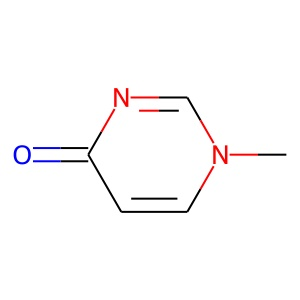
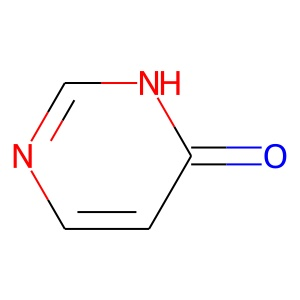
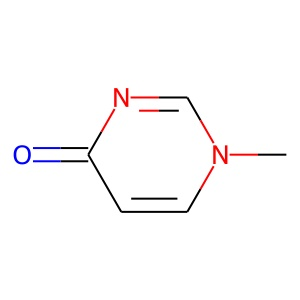
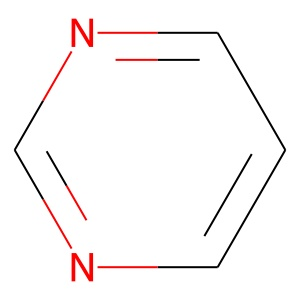
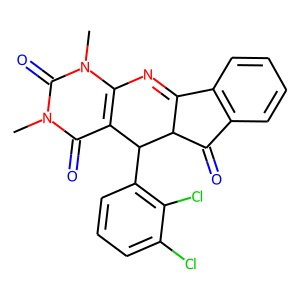
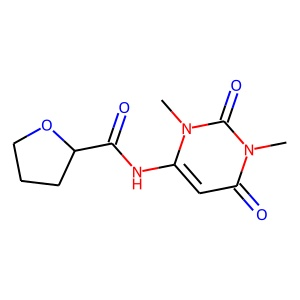
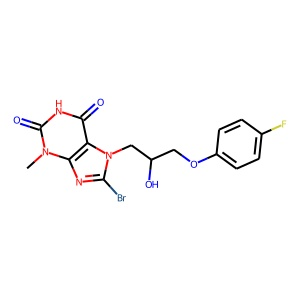
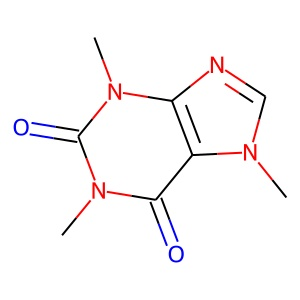
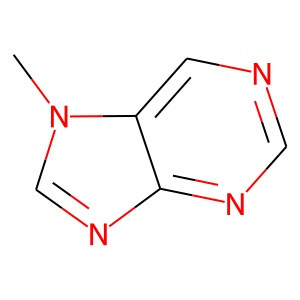
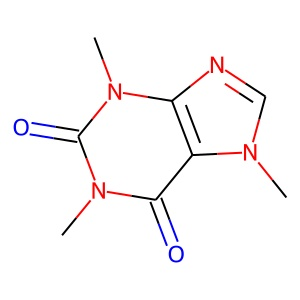
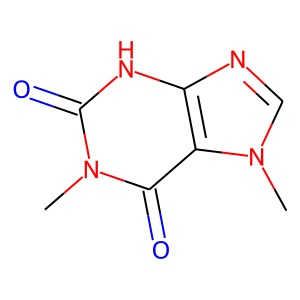
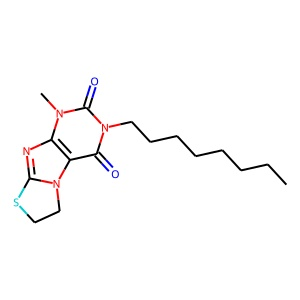
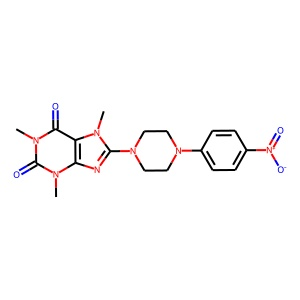
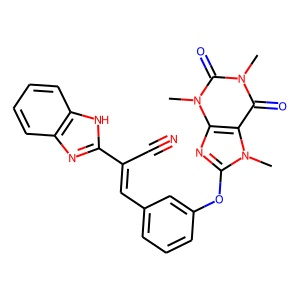
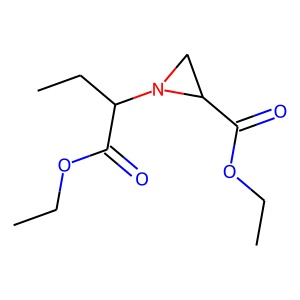
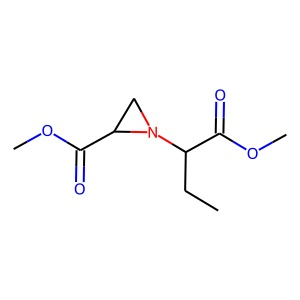
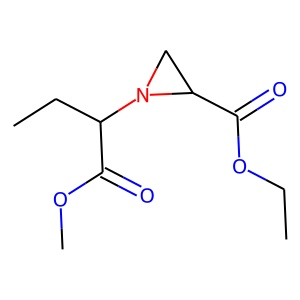
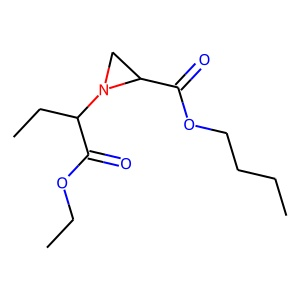
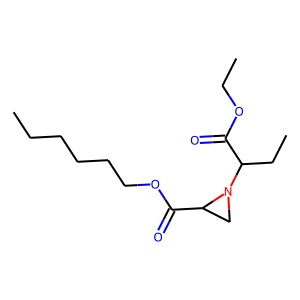

In [17]:
( towhee.dc['smiles'](['Cn1ccc(=O)nc1', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CCOC(=O)C1CN1C(C(=O)OCC)CC'])
      .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
      .milvus_search['fp', 'result_super'](collection=collection, metric_type='SUPERSTRUCTURE', limit=3)
      .milvus_search['fp', 'result_sub'](collection=collection, metric_type='SUBSTRUCTURE', limit=3)
      .runas_op['result_super', 'is_superstructure'](func=to_images)
      .runas_op['result_sub', 'is_substructure'](func=to_images)
      .runas_op['smiles', 'smiles'](func=to_images)
      .select['smiles', 'is_superstructure', 'is_substructure']()
      .show()
)

## Release a Showcase

We've done an excellent job on the core functionality of our molecular search engine. Now it's time to build a showcase with interface. [Gradio](https://gradio.app/) is a great tool for building demos. With Gradio, we simply need to wrap the data processing pipeline via a `search_smiles_with_metric` function:

In [18]:
def search_smiles_with_metric(smiles, metric_type):
    def smiles_to_pil(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return Draw.MolToImage(mol)
    
    with towhee.api() as api:
        milvus_search_function = (
            api.molecular_fingerprinting(algorithm='daylight')
                .milvus_search(collection='molecular_search', metric_type=metric_type, limit=5)
                .runas_op(func=lambda res: [smiles_to_pil(id_smiles[x.id]) for x in res])
                .as_function()
        )
    return milvus_search_function(smiles)

In [19]:
import gradio

interface = gradio.Interface(search_smiles_with_metric, 
                             [gradio.inputs.Textbox(lines=1, default='CN1C=NC2=C1C(=O)N(C(=O)N2C)C'), 
                              gradio.inputs.Radio(['JACCARD', 'substructure', 'superstructure'])],
                             [gradio.outputs.Image(type="pil", label=None) for _ in range(5)]
                            )

interface.launch(inline=True, share=True)

/Users/chenshiyu/.virtualenvs/shiyu/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://10754.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x3ec90ebe0>,
 'http://127.0.0.1:7860/',
 'https://10754.gradio.app')